In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import RANSACRegressor

In [2]:
depth = np.load(open('keto_images/keto_hammer_1_depth.npy', 'rb'))


In [3]:
params = {'fx': 372.66, 'tx': 241.20, 'fy': 368.62, 'ty': 214.19}

In [4]:
def depth_to_point_cloud(depth, params, z_min=0.00, z_max=0.20):
    height, width = depth.shape
    u = np.tile(np.arange(width).reshape([1, width]), [height, 1])
    v = np.tile(np.arange(height).reshape([height, 1]), [1, width])
    u = np.reshape(u, [height, width, 1])
    v = np.reshape(v, [height, width, 1])
    z = np.reshape(depth, [height, width, 1])
    x = (u - params['tx']) * z / params['fx']
    y = (v - params['ty']) * z / params['fy']
    mask = np.logical_and(z > z_min, z < z_max).flatten()
    point_cloud = np.concatenate([x, y, z], axis=2)
    p = np.reshape(point_cloud, [-1, 3])[mask]
    return p

def segment_object(p, r=0.03, num_points=1024):
    num_points = p.shape[0]
    reg = RANSACRegressor().fit(p[:, :2], p[:, 2])
    z_plane = reg.predict(p[:, :2])
    mask = p[:, 2] < z_plane - 8e-4
    mask = np.logical_and(mask, np.linalg.norm(p[:, :2], axis=1) < r)
    p_obj = p[mask]
    p_obj = p_obj - np.mean(p_obj, axis=0, keepdims=True)
    indices = np.random.randint(p_obj.shape[0], size=num_points)
    p_obj = p_obj[indices]
    return p_obj


In [5]:
point_cloud = depth_to_point_cloud(depth, params)
point_cloud = segment_object(point_cloud)

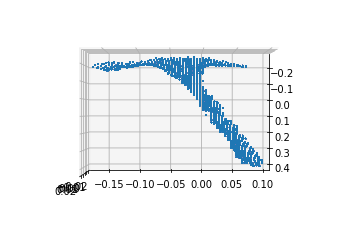

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(90, 0)
ax.scatter(point_cloud[:, 0] * 20, point_cloud[:, 1] * 20, point_cloud[:, 2] * 20, s=0.1)

In [ ]:
plt.imshow(depth)